# ResNet

## Import Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [2]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.Flowers102(
    root = '../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

test_data = datasets.Flowers102(
    root='../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [4]:
training_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ../data/
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

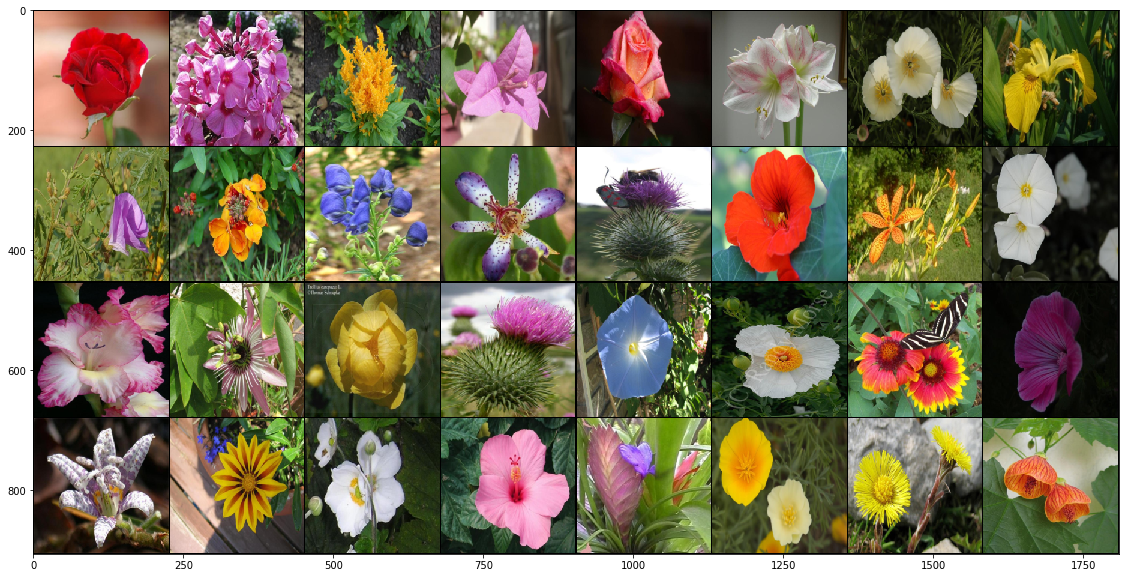

In [5]:
# sample images를 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_train = []
for batch, (X,y) in enumerate(train_dataloader):
    if batch<1:
        x_train.append(X)
    else:
        break


# tensor를 image로 변경하는 함수를 정의
def show(img):
    # tensor를 numpy array로 변경
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경
    npimg_tr = npimg.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력
# 총 40개 이미지, 행당 8개 이미지를 출력
x_grid = utils.make_grid(x_train[0][:40], nrow=8, padding=2)

show(x_grid)

## Define Model

In [18]:
import torchvision.models as model

non_pretrained_ResNet = model.resnet152()
summary(non_pretrained_ResNet,(3,224,224),batch_size=32)
non_pretrained_ResNet.to(mps_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Use Pretrained ResNet-152

In [8]:
import torchvision.models as model

# get pretrained model
# pretrained_ResNet = model.resnet152(weights=model.ResNet152_Weights.DEFAULT)

# save weights
# torch.save(pretrained_ResNet.state_dict(),'resnet_152_weights.pth')

# load weights
# pretrained_ResNet = model.resnet152()
# pretrained_ResNet.load_state_dict(torch.load('vgg_16_weights.pth'))

# move model to GPU
# pretrained_ResNet.to(mps_device)

# Train

In [19]:
learning_rate = 0.1
epochs = 80
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(non_pretrained_ResNet.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0001)


In [20]:
train_acc, train_loss = [],[]
test_acc, test_loss = [],[]

In [81]:
# torch.save({
#     'epochs':epochs,
#     'model_state_dict' : vgg_16_model.state_dict(),
#     'optimizer_state_dict' : optimizer.state_dict(),
#     'train_acc' : train_acc,
#     'test_acc' : test_acc,
#     'train_loss' : train_loss,
#     'test_loss' : test_loss,
# }, 'vgg_16_model.pt')

In [82]:
# # How to load model checkpoint
# vgg_16_model = model.vgg16()
# vgg_16_model = nn.Sequential(
#     vgg_16_model,
#     nn.ReLU(),
#     nn.Dropout(),
#     nn.Linear(1000,102)
# )
# vgg_16_model.to(mps_device)

# optimizer = torch.optim.SGD(vgg_16_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# checkpoint = torch.load('vgg_16_model.pt')
# vgg_16_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epochs = checkpoint['epochs']
# train_acc = checkpoint['train_acc']
# test_acc = checkpoint['test_acc']
# train_loss = checkpoint['train_loss']
# test_loss = checkpoint['test_loss']


In [21]:
for t in range(epochs):
    tr_acc, tr_loss = train_loop(True,'GPU',train_dataloader,non_pretrained_ResNet,loss_fn,optimizer)
    te_acc, te_loss = test_loop(False, 'GPU',test_dataloader, non_pretrained_ResNet, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss[-1])
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    print(f'epoch {t+1}')
    print('train loss: %.6f train acc: %.2f\ntest  loss: %.6f, test acc: %.2f' %(tr_loss[-1],100*tr_acc, te_loss, 100*te_acc))
    print('-'*10)

loss: 7.246960 [    0/ 1020]
loss:     inf [  320/ 1020]
loss: 7.015216 [  640/ 1020]
loss: 7.159092 [  960/ 1020]
epoch 1
train loss: 7.159092 train acc: 0.00
test  loss: 6.051549, test acc: 1.37
----------
loss: 5.955618 [    0/ 1020]
loss: 5.742843 [  320/ 1020]
loss: 5.144324 [  640/ 1020]
loss: 5.068336 [  960/ 1020]
epoch 2
train loss: 5.068336 train acc: 0.00
test  loss: 5.131081, test acc: 1.37
----------
loss: 5.034561 [    0/ 1020]
loss: 5.208526 [  320/ 1020]
loss: 5.009719 [  640/ 1020]
loss: 4.753436 [  960/ 1020]
epoch 3
train loss: 4.753436 train acc: 0.00
test  loss: 4.860731, test acc: 1.08
----------
loss: 4.667639 [    0/ 1020]
loss: 4.968788 [  320/ 1020]
loss: 5.056946 [  640/ 1020]
loss: 4.919080 [  960/ 1020]
epoch 4
train loss: 4.919080 train acc: 0.00
test  loss: 4.757972, test acc: 1.47
----------
loss: 4.771327 [    0/ 1020]
loss: 4.795223 [  320/ 1020]
loss: 4.751964 [  640/ 1020]
loss: 4.677003 [  960/ 1020]
epoch 5
train loss: 4.677003 train acc: 0.00
test

In [17]:
torch.save({
    'epochs':10,
    'model_state_dict' : non_pretrained_ResNet.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_acc' : train_acc,
    'test_acc' : test_acc,
    'train_loss' : train_loss,
    'test_loss' : test_loss,
}, 'non_pretrained_ResNet.pt')

## Result of Flowers102 Dataset

### Begin with Pretrained Weight

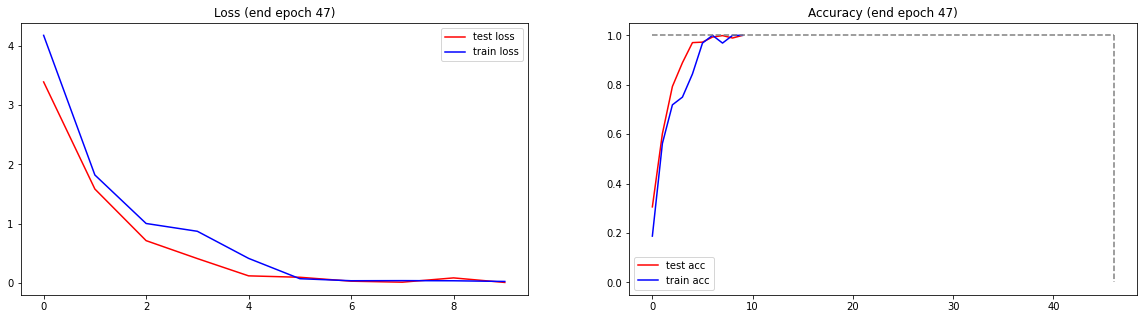

In [15]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.plot([0,46],[1,1],'--',color='gray')
ax.plot([46,46],[1,0],'--',color='gray')
ax.legend()

### Begin with non-Pretrained Weights

### SGD & Adam

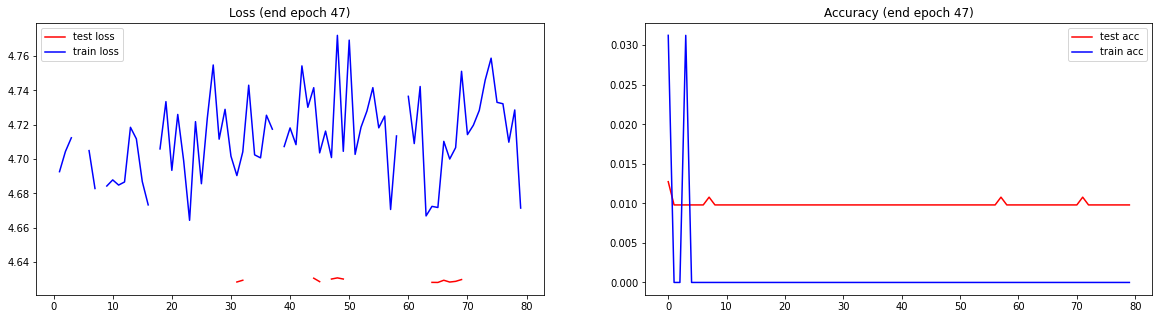

In [86]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()